In [18]:
# Connect to Google Drive
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
# do all of the imports
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from numpy import arange
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import export_graphviz
import pydot
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
import joblib

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Utility Function for history plotting
# adapted from a RealPython tutorial: 
#    https://realpython.com/python-keras-text-classification/
def plot_history(history, file_name):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig(file_name, bbox_inches='tight')

In [ ]:
# Utility Function for data cleaning pipeline
def text_pipeline(row):
    genre = row["genre"]
    descr = row["description"]
    text = genre + " " + descr
    # split into words
    tokens = word_tokenize(text)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # join the words and return them to be loaded into the dataframe
    return " ".join(words)

In [ ]:
!ls gdrive/MyDrive/Colab\ Notebooks/Final-Project/Resource/
!pwd

IMDb_movies.csv  IMDB_sean.csv
/content


In [ ]:
# Load in the IMDB_sean file
df = pd.read_csv("gdrive/MyDrive/Colab Notebooks/Final-Project/Resource/IMDB_sean.csv")
df.head()

,Unnamed: 0,title,year,genre,description,budget,usa_gross_income,worlwide_gross_income,profit_factor
0,165,Il gabinetto del dottor Caligari,1920,"Fantasy, Horror, Mystery","Hypnotist Dr. Caligari uses a somnambulist, Ce...",18000.0,8811.0,8811.0,loss
1,245,I quattro cavalieri dell'Apocalisse,1921,"Drama, Romance, War",An extended family split up in France and Germ...,800000.0,9183673.0,9183673.0,large gain
2,506,Metropolis,1927,"Drama, Sci-Fi",In a futuristic city sharply divided between t...,6000000.0,1236166.0,1349711.0,loss
3,1048,Luci della città,1931,"Comedy, Drama, Romance","With the aid of a wealthy erratic tippler, a d...",1500000.0,19181.0,46008.0,loss
4,2454,Tempi moderni,1936,"Comedy, Drama, Family",The Tramp struggles to live in modern industri...,1500000.0,163577.0,457688.0,loss


In [ ]:
 # Run the Genre and Description thru the text pipeline for joining and cleaning
 df["words"] = df.apply(text_pipeline, axis=1)
 df.head()
 print(df["words"].map(lambda x: len(x)).max())

315


In [ ]:
# Define the X and y parameters
sentences = df["words"].values
y = df["profit_factor"].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=42)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

# scale the data with StandardScaler
X_scaler = MaxAbsScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Label Encode data set
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
joblib.dump(label_encoder, "gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/sean_random_forest_le.sav")
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

print(f"Shape X_test_scaled: {np.shape(X_test_scaled)}")
print(f"Shape encoded_y_test: {np.shape(encoded_y_test)}")

Shape X_test_scaled: (2028, 15709)
Shape encoded_y_test: (2028,)


In [ ]:
# Run Random Forest
classifier = RandomForestClassifier(n_estimators=200)
classifier.fit(X_train_scaled, encoded_y_train)
score = classifier.score(X_test_scaled, encoded_y_test)

print("Accuracy:", score)
print(f"Training Data Score: {classifier.score(X_train_scaled, encoded_y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_scaled, encoded_y_test)}")

Accuracy: 0.36439842209072976
Training Data Score: 0.9990133201776024
Testing Data Score: 0.36439842209072976


In [ ]:
# Hyperparameter Tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model_random = RandomizedSearchCV(estimator=classifier, param_distributions=param_grid, n_iter=10, verbose=3, random_state=42)
# commented out while I work on the analysis code
#model_random.fit(X_train_scaled, encoded_y_train)

In [ ]:
# print(model_random.best_params_)
# print(model_random.best_score_)

In [ ]:
# Save the Model
file_name = "gdrive/MyDrive/Colab Notebooks/Final-Project/Saved_Models/sean_Random_Forest.sav"
joblib.dump(model_random.best_estimator_, file_name, compress = 1)

In [ ]:
export_graphviz(model_random.best_estimator_[0], out_file="gdrive/MyDrive/Colab Notebooks/Final-Project/rf_tree.dot")

In [ ]:
(graph,) = pydot.graph_from_dot_file("gdrive/MyDrive/Colab Notebooks/Final-Project/rf_tree.dot")

In [ ]:
graph.write_png("gdrive/MyDrive/Colab Notebooks/Final-Project/Images/RF_Tree.png")

>0.1 0.354 (0.013)
>0.2 0.351 (0.016)
>0.3 0.358 (0.011)
>0.4 0.354 (0.013)
>0.5 0.356 (0.017)
>0.6 0.357 (0.012)
>0.7 0.355 (0.014)
>0.8 0.356 (0.015)
>0.9 0.357 (0.014)
>1.0 0.354 (0.015)


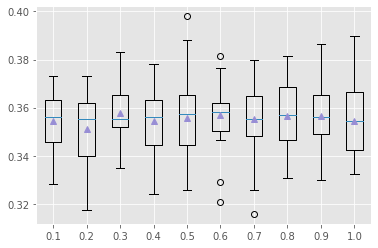

In [ ]:
# Explore Sample Size
# get a list of models to evaluate
def get_models():
	models = dict()
	# explore ratios from 10% to 100% in 10% increments
	for i in arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		# set max_samples=None to use 100%
		if i == 1.0:
			i = None
		models[key] = RandomForestClassifier(max_samples=i)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define dataset
X, y = X_train_scaled, encoded_y_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
file_name = "gdrive/MyDrive/Colab Notebooks/Final-Project/Images/RF_SampleSize.png"
plt.savefig(file_name, bbox_inches='tight') 
plt.show()

>1028 0.359 (0.017)
>1228 0.357 (0.015)
>1428 0.358 (0.016)
>1628 0.359 (0.016)
>1828 0.356 (0.018)


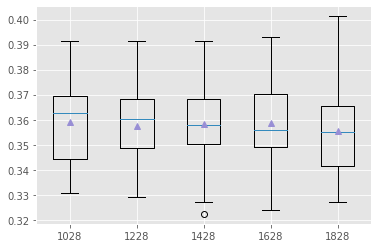

In [ ]:
# explore feature effects
# get a list of models to evaluate
def get_models():
	models = dict()
	# explore number of features from 1 to 7
	for i in range(1028, 2028, 200):
		models[str(i)] = RandomForestClassifier(max_features=i)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
X, y = X_train_scaled, encoded_y_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
file_name = "gdrive/MyDrive/Colab Notebooks/Final-Project/Images/RF_FeatureSize.png"
plt.savefig(file_name, bbox_inches='tight') 
plt.show()

>30 0.356 (0.010)
>40 0.359 (0.009)
>50 0.362 (0.010)
>60 0.360 (0.011)
>70 0.360 (0.010)
>80 0.360 (0.012)
>None 0.355 (0.014)


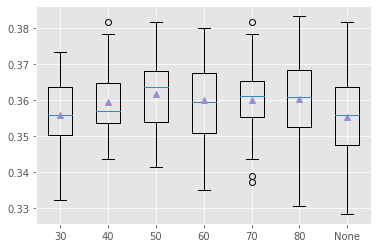

In [20]:
# explore random forest tree depth effect on performance
# Code is based on code from : https://machinelearningmastery.com/random-forest-ensemble-in-python/
# get a list of models to evaluate
def get_models():
	models = dict()
	# consider tree depths from 30 to 80 and None=full
	depths = [i for i in range(30,81,10)] + [None]
	for n in depths:
		models[str(n)] = RandomForestClassifier(max_depth=n)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
X, y = X_train_scaled, encoded_y_train
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
file_name = "gdrive/MyDrive/Colab Notebooks/Final-Project/Images/RF_TreeSize.png"
plt.savefig(file_name, bbox_inches='tight') 
plt.show()